In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from IPython.display import display, HTML
# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans

#import my modules
import acquire as a
import prepare as p
import wrangle_zillow as w
import explore as ex

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Acquire

In [ ]:
df = a.get_zillow()

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
#getting the latest transactions 
df = df.sort_values(by ='transactiondate', ascending=True).drop_duplicates( subset = 'parcelid' ,keep= 'last')
  

In [ ]:
df.shape

In [ ]:
#this list has all types of single unit properties
single= ['Single Family Residential',' Mobile Home' , 'Townhouse ', 'Manufactured, Modular, Prefabricated Homes'  ]

In [ ]:
#create a mask
single_mask = df['propertylandusedesc'].isin(single)

In [ ]:
#if unitcnt == that's means is is a single property but if it is null we can compare with our list of single

In [ ]:
#using that mask and also add  a condition
df_single = df[single_mask & ((df['unitcnt'] == 1) | (df['unitcnt'].isnull()))]
    

In [ ]:
#this df contains all single unit homes of 2017 with the latest transaction
df_single.shape

In [ ]:
a.summarize(df_single)

**takeaways**
- numberofstories there is one property with 6 stories , I would drop it!
- unitcnt is not needed any more. I would drop it
- there are a lot of nulls so in preparation step I will handle them

# Preparation

In [ ]:
p.miss_dup_values(df_single)

In [ ]:
df_single.shape

In [ ]:
# I will drop columns and rows with a lot of null values 
#here I will include unitcnt because the value is 1 for all the properties . as it is the next to 65.6% 
#I can include it in my function
df_single= p.handle_missing_values(df_single, prop_required_columns=0.75, prop_required_row=0.75)

In [ ]:
df_single.shape

In [ ]:
p.miss_dup_values(df_single)

In [ ]:

#all these  columns represent a minimun amount so I can drop them 
df_single= p.drop_low_missing_values(df_single, per= 3 )

In [ ]:
df_single.shape

In [ ]:
p.miss_dup_values(df_single)

In [ ]:
a.summarize(df_single)

In [ ]:
p.distribution(df_single)

### get county names and create dummy variables with those

In [ ]:
# create dummy vars of fips id
county_df = pd.get_dummies(df_single.fips)

In [ ]:
county_df.head()

- county # 6037 -----> Los Angeles
- county # 6059 -----> Orange
- county # 6111 -----> Ventura

In [ ]:
#df_single = p.get_counties(df_single)

In [ ]:
# print("LA County Verified: ", df_single[df_single.fips==6037]['fips'].count() == df_single.los_angeles.sum())
# print("Orange County Verified: ", df_single[df_single.fips==6059]['fips'].count() == df_single.orange.sum())
# print("Ventura County Verified: ", df_single[df_single.fips==6111]['fips'].count() == df_single.ventura.sum())

In [ ]:
#now in my function I can drop fips

###  Compute new features out of existing features in order to reduce noise, capture signals, and reduce collinearity, or dependence between independent variables.

**- age**

In [ ]:
df_single['age'] = 2017 - df.yearbuilt

In [ ]:
df_single.head()

In [ ]:
df_single[['age']].describe()

In [ ]:
# I can drop yearbuilt

**- taxrate**


In [ ]:
df_single['taxrate'] = df_single.taxamount/df_single.taxvaluedollarcnt*100

In [ ]:
df_single[['taxrate']].describe()

In [ ]:
# I will drop taxamount and taxvaluedollarcnt

**- transactiondate**


In [ ]:
df_single[['transactiondate']].head()

In [ ]:
#I decided to convert transaction date to int so in the future can make groups

In [ ]:
df_single['transactiondate']=(df_single['transactiondate'].str.replace(' ','').str.replace('-',''))

In [ ]:
df_single['transactiondate'] = df_single['transactiondate'].astype('int')

In [ ]:
#df_single[(df_single.transactiondate >= 20170101) &  (df_single.transactiondate < 20170501)]

In [ ]:
#try to bin transaction date
df_single['quadrimester'] = pd.cut(df_single.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230])

In [ ]:
df_single['quadrimester'].value_counts()

In [ ]:
#this is just to check if bins are correct
#this is the fist quadrimester
(df_single['transactiondate']<20170501).sum()

In [ ]:
#this is the second quadrimester
((df_single['transactiondate']>= 20170501)  & (df_single['transactiondate']<20170901)).sum()

In [ ]:
#this is the third quadrimester
((df_single['transactiondate']>= 20170901)  & (df_single['transactiondate']<20171232)).sum()

In [ ]:
#try to bin transaction date
df_single['quadrimester'] = pd.cut(df_single.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230],
                                 labels = [1,2,3])

In [ ]:
df_single['quadrimester'].value_counts()

In [ ]:
df_single[['transactiondate', 'quadrimester']].sample(30)

In [ ]:
df_single.info()

In [ ]:
df_single['lotsize_acres'] = df_single.lotsizesquarefeet/43560
df_single = df_single.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])

In [ ]:
def create_features (df) :
    '''
    takes in a df and create age , taxrate, lotsize_acres columns and convert transactiondate to int
    drops 'yearbuilt', 'taxamount', 'taxvaluedollarcnt', lotsizesquarefeet columns
    '''
    #create a new colum with age
    df['age'] = 2017 - df.yearbuilt
    
    #taxrate
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100
    
  #transactiondate
    df['transactiondate']=(df['transactiondate'].str.replace(' ','').str.replace('-',''))
    df['transactiondate'] = df['transactiondate'].astype('int')
    #try to bin transaction date
    df['quadrimester'] = pd.cut(df.transactiondate, bins = [ 20170100, 20170500, 20170900, 20171230],
                                 labels = [1,2,3])
     # create acres variable
    df['lotsize_acres'] = df.lotsizesquarefeet/43560
    
    #drop columns
    df = df.drop(columns = ['yearbuilt', 'taxamount', 'taxvaluedollarcnt', 'lotsizesquarefeet'  ])
    
    return df

In [ ]:
df_single.columns

In [ ]:
# I will handle outliers for : 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 
#'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age'

In [ ]:
df_single.head()

In [ ]:
col = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'regionidzip', 'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxrate', 'lotsize_acres', 'age']

In [ ]:
df_final= p.remove_outliers(df_single, col)

In [ ]:
df_final.describe().T


In [ ]:
df_final.lotsize_acres.describe()

In [ ]:
p.distribution_boxplot(df_final)

In [ ]:
df_final.shape, df_single.shape

In [ ]:
df_final['regionidcity'].value_counts()

In [ ]:
df_final.info()

In [ ]:
# here I can drop
# propertylandusedesc 

In [2]:
#checking wrangle_zillow function
train, validate, test= w.wrangle_zillow()

before outliers (50819, 24)
df shape --> (34126, 23)
train -> (19110, 23)
validate -> (8190, 23)
test -> (6826, 23)


In [ ]:
((50819-34126)*100) / 50819

In [ ]:
scal_var = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet','latitude', 'longitude', 
            'structuretaxvaluedollarcnt', 'age', 'taxrate', 'lotsize_acres']

In [ ]:
#train_scaled_df, validate_scaled_df, test_scaled_df = p.scaled_df( train , validate, test, scal_var, MinMaxScaler())

# Explore 

explore target

In [ ]:
plt.figure(figsize=(13, 8))
train['logerror'].hist(grid=False, color = 'teal')
plt.xlabel("logerror")
plt.ylabel("Number of properties")                               
plt.xlim(-2 ,3)
plt.show()

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(train['logerror'])
plt.xlim(-.25 ,.25)
plt.show()

In [ ]:
train['logerror'].describe()

In [ ]:
train.logerror_bins.value_counts()

In [ ]:
train.info()

In [ ]:
ex.plot_variable_pairs(train, 'logerror')

In [ ]:
plt.figure(figsize=(13, 6))
ex.heatmap(train)

In [ ]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-3, vmax=3, annot=True, cmap='coolwarm')

**takeaways**
-logerror does not correlate well with any one feature
    - landtaxvaluedollarcnt is the highest
- Because of the lack of correlation, clustering is the next step.

In [ ]:
train.columns

In [ ]:
sns.pairplot(data = train, hue = 'logerror_bins',
             x_vars = ['logerror', 'structuretaxvaluedollarcnt', 'quadrimester', 'taxrate', 
                       'bedroomcnt','latitude','landtaxvaluedollarcnt'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'lotsize_acres', 'age', 'longitude', 'county_name'])

takeaways 
- the log error is low for the houses less than 20 years old  that were sold in the 2nd and 3rd quadrimester
- the range of log error is higher for the houses  that are 50 -70 years old
- the range of logerror is low for the lower and higher lot sizes
- the range of logerror is low for the lower and higher calculatedfinishedsqrefeet
- the logerror is low for the calculatedfihishedsquarefeet >1500 and with 4 bedrooms
- the logerror is low for 2.5 -3 bathrooms and were sold jan -dic
- the log error for a 5bedrooms is low with 1 -4 bathrooms except 2 bathrooms
- the range of log error in 3.5 baths is low
- 1st quadrimester  los angesles county has thwe less logerrror
- 2nd quadrimester (hot mohts) all three counties has less logerror
- 3rd quadrimester  Orange county has the less logerrror

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='latitude', y='longitude', hue='logerror_bins', data=train)
plt.legend()
plt.title('Geolocation and Logerror')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='latitude', y='longitude', hue='county_name', data=train)
plt.legend()
plt.title('Geolocation and Logerror')
plt.show()

In [ ]:
plt.figure(figsize=(14,8))
sns.scatterplot(x ='bedroomcnt', y = 'bathroomcnt', hue= 'logerror_bins', data = train)
plt.legend(bbox_to_anchor=(1.2,.8))

## Statistical Tests

- T-test

### LA county vs Orange County

- 𝐻𝑜: there is no difference in average of logerror between  Los Angeles  and Orange Counties
- 𝐻𝑎 There is a signifficant average of logerror between  Los Angeles  and Orange Counties

1. Set Significance Level: $\alpha = .05$ (in other words Confidence level is 0.95)

2. Verify Assumptions:

    - Normal Distribution, or at least 30 observations and "kinda" normal. The more observations you have, the less "normal" it needs to appear. (CLT)
    - Independent samples
    - Equal Variances (or set method argument to False when not)
3. Compute test statistic and probability (t-statistic & p-value) using stats.ttest_ind

In [ ]:

# Set Significance Level
alpha = 0.05

In [ ]:
train.head()

In [ ]:
#create my groups
la = train[train.la_cnty == 1].logerror
orange = train[train.orange_cnty ==1 ].logerror

In [ ]:
#Normal Distribution
la.shape, orange.shape

In [ ]:
# Equal Variances (or set method argument to False when not)
la.var(), orange.var()

In [ ]:
#inequal variance

In [ ]:
#Compute Test Statistic
t, p = stats.ttest_ind(la, orange, equal_var = False)
t,p

In [ ]:
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

### landtaxvaluedollarcnt vs logerror

- 𝐻𝑜: there is no linear relationship between  logerror and  landtaxvaluedollarcnt
- 𝐻𝑎: there is a linear relationship between  logerror and  landtaxvaluedollarcnt

**Pearson R**

In [ ]:
r, p = stats.pearsonr(train['landtaxvaluedollarcnt'], train['logerror'])
r,p

In [ ]:
if (p < alpha):
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

###  Data exploration with Clusters

- **1st Clustering Combination: Clustering for bedrooms and bathrooms**

In [3]:
def create_cluster(df,validate, test, X, k, name):
    
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe"""
    
    scaler = StandardScaler(copy=True).fit(df[X])
    X_scaled = pd.DataFrame(scaler.transform(df[X]), columns=df[X].columns.values).set_index([df[X].index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    df[name] = kmeans.predict(X_scaled)
    df[name] = 'cluster_' + df[name].astype(str)
    
    v_scaled = pd.DataFrame(scaler.transform(validate[X]), columns=validate[X].columns.values).set_index([validate[X].index.values])
    validate[name] = kmeans.predict(v_scaled)
    validate[name] = 'cluster_' + validate[name].astype(str)
    
    t_scaled = pd.DataFrame(scaler.transform(test[X]), columns=test[X].columns.values).set_index([test[X].index.values])
    test[name] = kmeans.predict(t_scaled)
    test[name] = 'cluster_' + test[name].astype(str)
    
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return df, X_scaled, scaler, kmeans, centroids

In [4]:
def make_this_cluster(train, validate, test, col_list, k, col_name = None):
    '''
    Function takes in already scaled train validate and test,
    k number of clusters you want to make,
    col_list list of the columns you want to be in the cluster
    Optional argument col_name, If none is entered column returned is 'clusters'
    Returns dataframes with column attached, and the kmeans object
    Returns: train, validate, test, kmeans
    '''
    


    #Fit Thing
    kmeans.fit(train[col_list])
    
    if col_name == None:
        # add cluster predictions on dataframe generic
        train['clusters'] = kmeans.predict(train[col_list])
        validate['clusters'] = kmeans.predict(validate[col_list])
        test['clusters'] = kmeans.predict(test[col_list])
    else:
        # add cluster predictions on dataframe specific name
        train[col_name] = kmeans.predict(train[col_list])
        validate[col_name] = kmeans.predict(validate[col_list])
        test[col_name] = kmeans.predict(test[col_list])
        
    
    return train, validate, test, kmeans

In [5]:
def create_scatter_plot(x,y,df,kmeans, X_scaled, scaler, name):
    
    """ Takes in x and y (variable names as strings, along with returned objects from previous
    function create_cluster and creates a plot"""
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = df, hue = name)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')
    plt.legend(bbox_to_anchor=(1.2,.8))

In [6]:
# What value of k is appropriate?

def scatter_plot_ks (X_df, X_scaled_df, x, y, start, finish):
    fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

    for ax, k in zip(axs.ravel(), range(start , finish)):
        clusters = KMeans(k).fit(X_scaled_df).predict(X_scaled_df)
        ax.scatter(X_df[x], X_df[y], c=clusters)
        ax.set(title='k = {}'.format(k), xlabel=x, ylabel=y)

In [7]:
# let's explore based on annual_income and spending score
def elbow_chart ( X, end_range):
    scaler = StandardScaler().fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

    
    # let is explore what values of k might be appropriate
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(9, 6))
        pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, end_range)}).plot(marker='x')
        plt.xticks(range(2, end_range))
        plt.xlabel('k')
        plt.ylabel('inertia')
        plt.title('Change in inertia as k increases')

- **1st Clustering Combination: Clustering for age and bathrooms**

In [8]:
X = ['age', 'bedroomcnt']

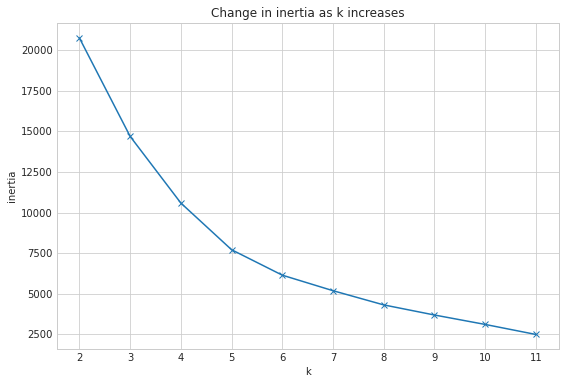

In [9]:
elbow_chart (train[X] , 12)

In [10]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, validate, test, X , 5 , 'cluster_age_bed')

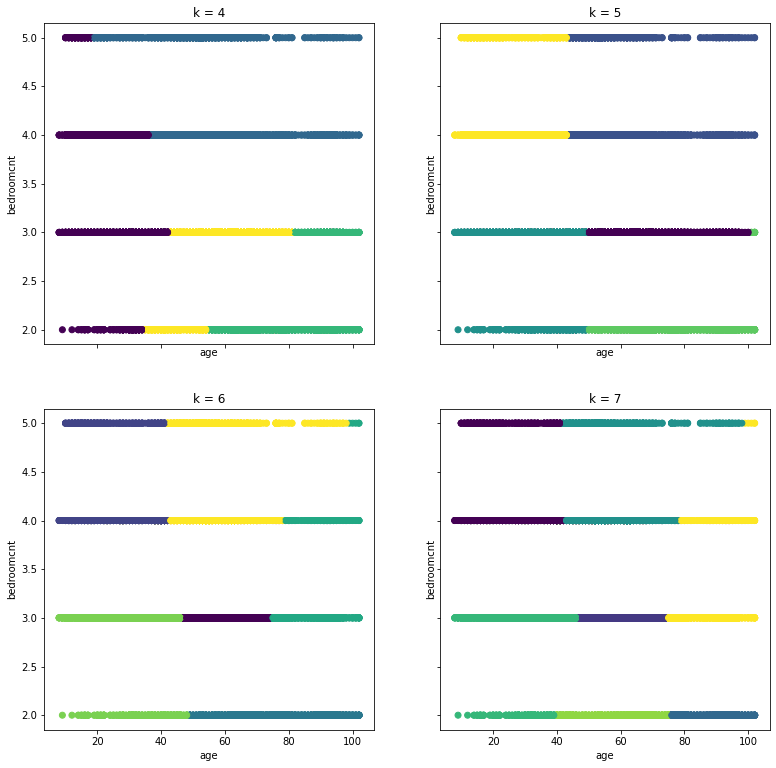

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(4, 9)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(train.age, train.bedroomcnt, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='age', ylabel='bedroomcnt')

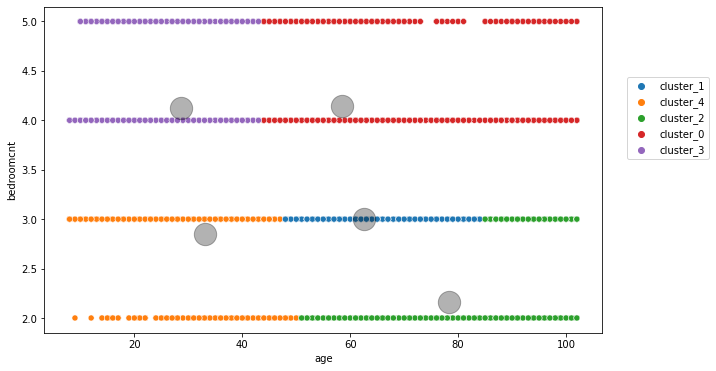

In [12]:
 create_scatter_plot('age','bedroomcnt',df,kmeans, X_scaled, scaler, 'cluster_age_bed')

In [13]:
train.groupby('cluster_age_bed').describe().T

cluster_age_bed        cluster_0    cluster_1    cluster_2    cluster_3  \
bathroomcnt   count  3928.000000  6179.000000  3520.000000  2306.000000   
              mean      2.377419     1.876679     1.365625     2.791414   
              std       0.582013     0.526496     0.529988     0.466988   
              min       1.000000     1.000000     1.000000     2.000000   
              25%       2.000000     2.000000     1.000000     2.500000   
...                          ...          ...          ...          ...   
lotsize_acres min       0.033356     0.032507     0.032438     0.037466   
              25%       0.138246     0.136019     0.115645     0.122572   
              50%       0.163476     0.152893     0.137741     0.152330   
              75%       0.188705     0.177468     0.160629     0.188510   
              max       0.281015     0.280992     0.280854     0.280946   

cluster_age_bed        cluster_4  
bathroomcnt   count  3177.000000  
              mean      2.319956  
              std       0.481887  
              min       1.000000  
              25%       2.000000  
...                          ...  
lotsize_acres min       0.032369  
              25%       0.082645  
              50%       0.125505  
              75%       0.164624  
              max       0.280992  

[144 rows x 5 columns]

In [14]:
cluster_list= (train.columns.to_list())[-5:]
cluster_list

['taxrate',
 'quadrimester',
 'lotsize_acres',
 'logerror_bins',
 'cluster_age_bed']

Statistical test

- $H_0$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.
- $H_a$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.

In [15]:
cluster0 = train[train.cluster_age_bed == 'cluster_0'].logerror
cluster1 = train[train.cluster_age_bed == 'cluster_1'].logerror
cluster2 = train[train.cluster_age_bed == 'cluster_2'].logerror
cluster3 = train[train.cluster_age_bed == 'cluster_3'].logerror
cluster4 = train[train.cluster_age_bed == 'cluster_4'].logerror

In [16]:
list_cluster = [cluster0,cluster1,cluster2,cluster3,cluster4]

In [17]:
train.logerror.mean()

0.015704631043368996

In [18]:
def stat_ttest (df,list_cluster, n_cluster):
    alpha=0.05
    for n in range (n_cluster):
        t,p = stats.ttest_1samp(list_cluster[n], train.logerror.mean())
        if (p < alpha):
            print(f'For cluster_{n}, We reject the null hypothesis')
           
        else:
            print(f'For cluster_{n}, We fail to reject the null hypothesis')
        print(f't = {t},    p= {p}')
        


In [19]:
stat_ttest (train, list_cluster, 5)

For cluster_0, We reject the null hypothesis
t = 3.5361991087882747,    p= 0.000410617654180583
For cluster_1, We fail to reject the null hypothesis
t = -1.0048889335570323,    p= 0.31498968968247015
For cluster_2, We fail to reject the null hypothesis
t = -1.9270444496129684,    p= 0.054054509652017066
For cluster_3, We fail to reject the null hypothesis
t = 1.1426282629636904,    p= 0.2533116356658754
For cluster_4, We fail to reject the null hypothesis
t = -1.39942627987784,    p= 0.16178284991565461


In [20]:
test.shape, train.shape, validate.shape

((6826, 24), (19110, 24), (8190, 24))


- 2nd Clustering Combination: longitude  and latitude

In [21]:
X = ['latitude', 'longitude']

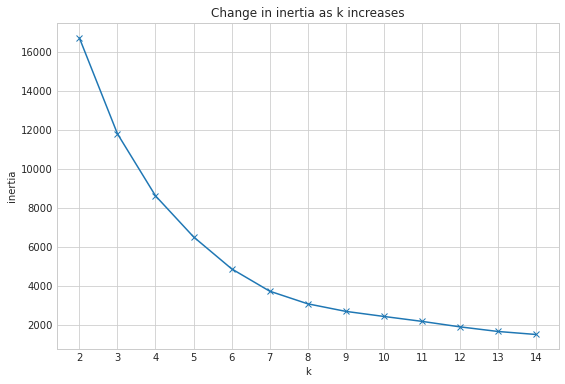

In [22]:
elbow_chart (train[X] , 15)

In [23]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, validate, test, X ,4 , 'cluster_lat_long')

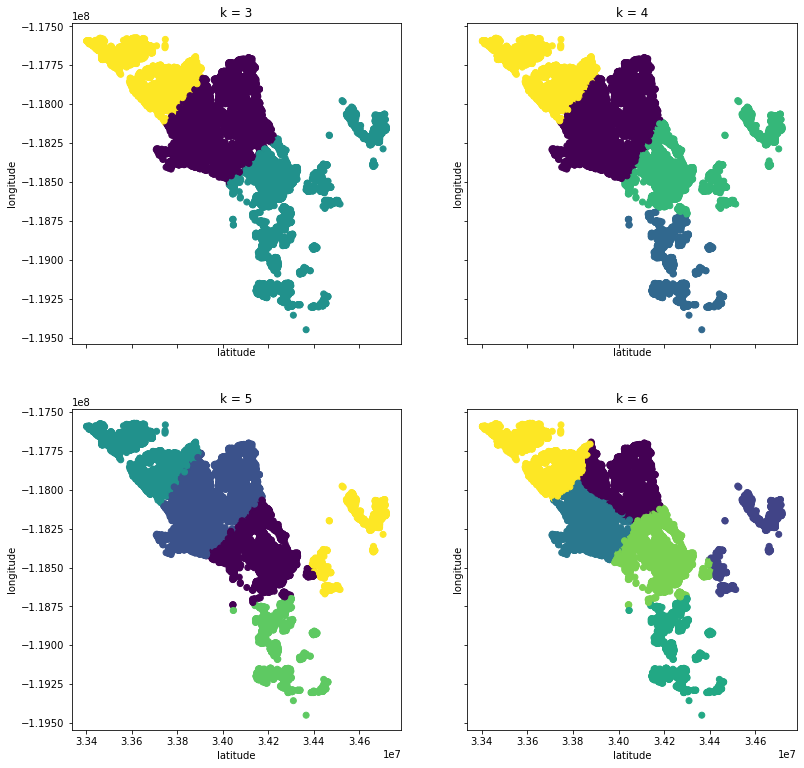

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(3, 7)):
    clusters = KMeans(k).fit(X_scaled).predict(X_scaled)
    ax.scatter(train.latitude, train.longitude, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='latitude', ylabel='longitude')

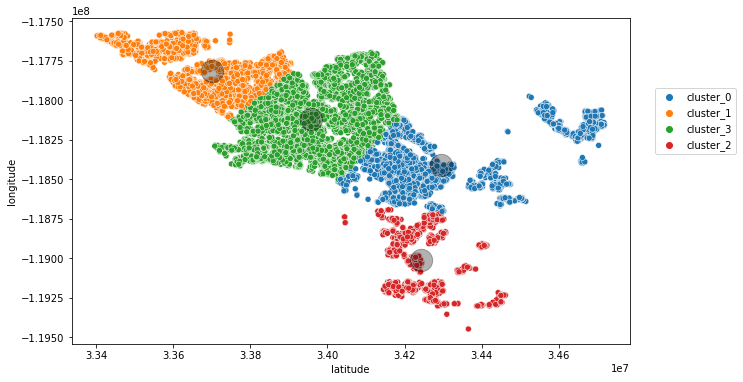

In [25]:
 create_scatter_plot('latitude','longitude',df,kmeans, X_scaled, scaler, 'cluster_lat_long')

In [26]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,propertylandusetypeid,regionidcity,regionidcounty,regionidzip,...,la_cnty,orange_cnty,ventura_cnty,age,taxrate,quadrimester,lotsize_acres,logerror_bins,cluster_age_bed,cluster_lat_long
54155,10820004,2.0,3.0,1433.0,34209445.0,-118505975.0,261.0,12447.0,3101.0,96415.0,...,1,0,0,67.0,1.208093,2,0.182484,"(-0.05, 0.05]",cluster_1,cluster_0
44501,14204400,3.0,3.0,3126.0,33860307.0,-117732319.0,261.0,16764.0,1286.0,97027.0,...,0,1,0,25.0,1.063828,2,0.151515,"(-0.05, 0.05]",cluster_4,cluster_1
77435,11468343,1.0,2.0,806.0,33957244.0,-118391943.0,261.0,12447.0,3101.0,96026.0,...,1,0,0,75.0,1.215730,3,0.135560,"(0.05, 0.2]",cluster_2,cluster_3
43382,13934312,2.0,4.0,1806.0,33790993.0,-117926578.0,261.0,24832.0,1286.0,97047.0,...,0,1,0,64.0,1.461827,2,0.167126,"(-0.05, 0.05]",cluster_0,cluster_1
34022,12837858,2.0,3.0,1851.0,34031627.0,-117917417.0,261.0,118694.0,3101.0,96488.0,...,1,0,0,59.0,1.285648,2,0.153926,"(-0.05, 0.05]",cluster_1,cluster_3


- $H_0$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.
- $H_a$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.

In [31]:
cluster0 = train[train.cluster_lat_long == 'cluster_0'].logerror
cluster1 = train[train.cluster_lat_long == 'cluster_1'].logerror
cluster2 = train[train.cluster_lat_long == 'cluster_2'].logerror
cluster3 = train[train.cluster_lat_long == 'cluster_3'].logerror


In [32]:
list_cluster = [cluster0,cluster1,cluster2,cluster3]

In [33]:
stat_ttest (train, list_cluster, 4)


For cluster_0, We fail to reject the null hypothesis
t = 0.942156435239411,    p= 0.3461639403814224
For cluster_1, We reject the null hypothesis
t = 1.9654416678737785,    p= 0.04942486579797325
For cluster_2, We fail to reject the null hypothesis
t = 0.26553456833653305,    p= 0.790630714752615
For cluster_3, We reject the null hypothesis
t = -1.9831177856816593,    p= 0.04738624439105686


-  Clustering Combination: lotsize_acres vs calculatedfinishedsquarefeet

In [34]:
X = ['lotsize_acres', 'calculatedfinishedsquarefeet']

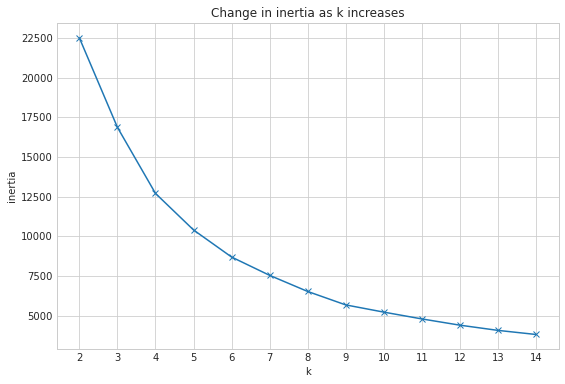

In [35]:
elbow_chart (train[X] , 15)

In [36]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, validate, test, X ,4 , 'cluster_lot_finish')

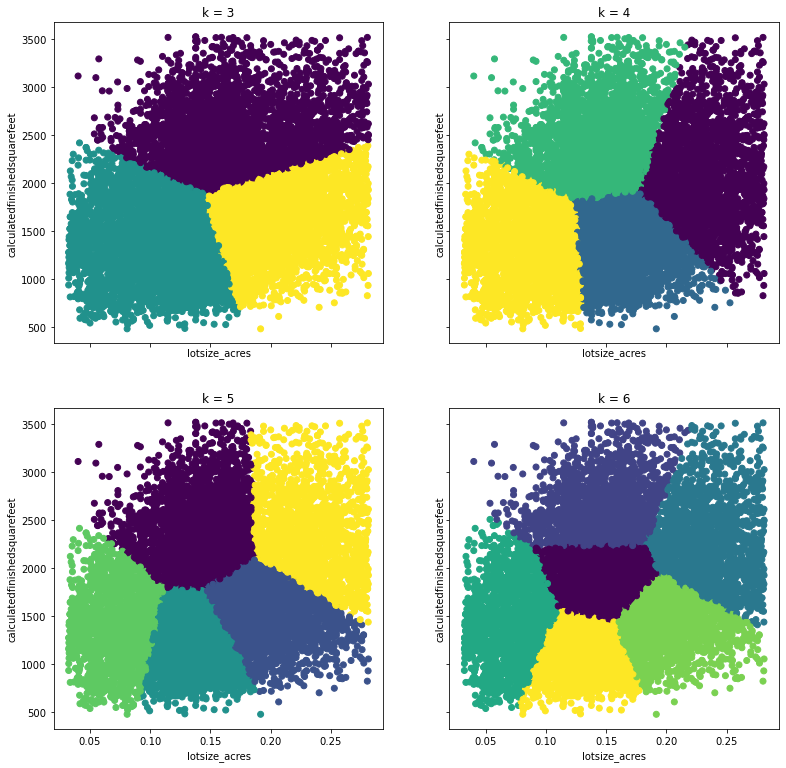

In [37]:
scatter_plot_ks (train, X_scaled, 'lotsize_acres','calculatedfinishedsquarefeet', 3, 7)

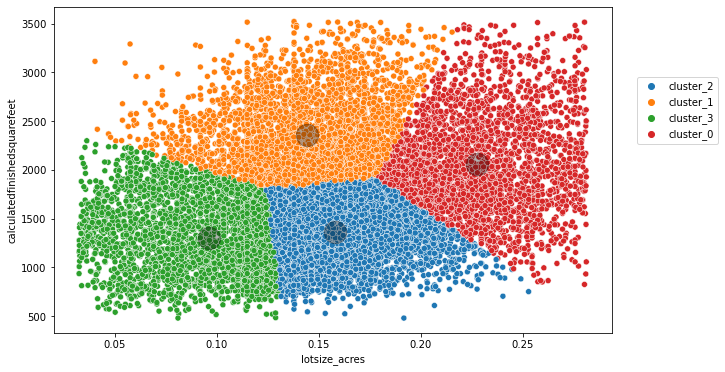

In [38]:
create_scatter_plot('lotsize_acres','calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler, 'cluster_lot_finish')

- $H_0$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.
- $H_a$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.

In [39]:
cluster0 = train[train.cluster_lot_finish == 'cluster_0'].logerror
cluster1 = train[train.cluster_lot_finish == 'cluster_1'].logerror
cluster2 = train[train.cluster_lot_finish == 'cluster_2'].logerror
cluster3 = train[train.cluster_lot_finish == 'cluster_3'].logerror

list_cluster = [cluster0,cluster1,cluster2,cluster3]

stat_ttest (train, list_cluster, 4)

For cluster_0, We fail to reject the null hypothesis
t = -0.2096875333391818,    p= 0.8339267949376981
For cluster_1, We reject the null hypothesis
t = 2.265141120859151,    p= 0.023560519537329676
For cluster_2, We fail to reject the null hypothesis
t = -1.061181483908628,    p= 0.2886382906727324
For cluster_3, We fail to reject the null hypothesis
t = -0.9559430159783061,    p= 0.33915569146381586


In [40]:
train.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'latitude', 'longitude', 'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'regionidzip', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'logerror', 'transactiondate', 'county_name',
       'la_cnty', 'orange_cnty', 'ventura_cnty', 'age', 'taxrate',
       'quadrimester', 'lotsize_acres', 'logerror_bins', 'cluster_age_bed',
       'cluster_lat_long', 'cluster_lot_finish'],
      dtype='object')

Clustering Combination: quadrimester vs county_name

In [41]:
X = ['quadrimester', 'regionidzip']

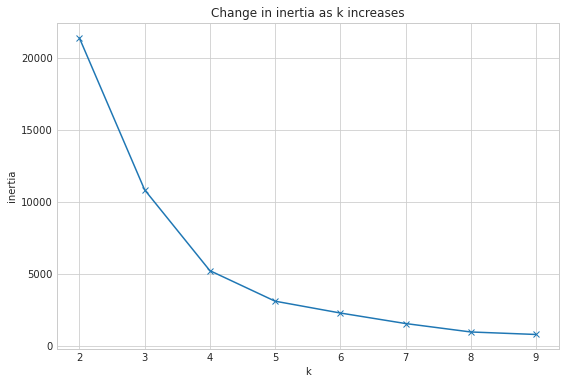

In [42]:
elbow_chart (train[X] , 10)

In [43]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, validate, test, X ,4 , 'cluster_quadrimester_zipcode')

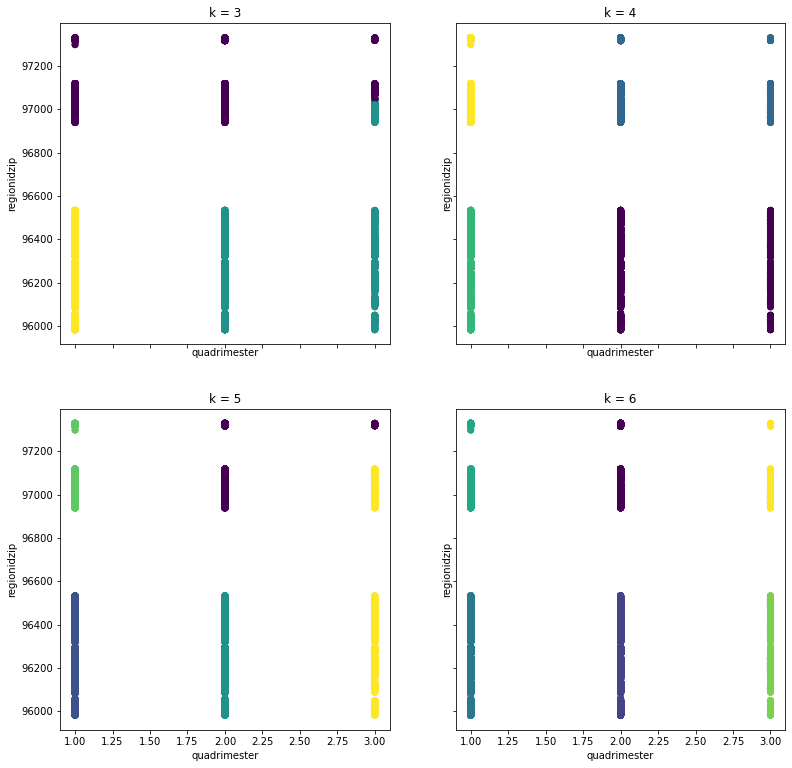

In [44]:
scatter_plot_ks (train, X_scaled, 'quadrimester','regionidzip', 3, 7)

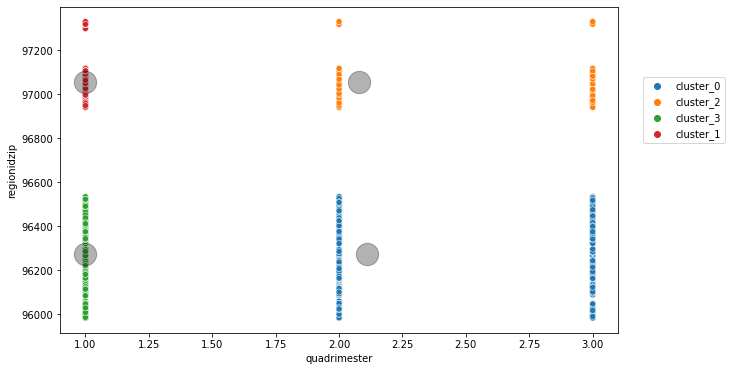

In [45]:
create_scatter_plot('quadrimester','regionidzip',df,kmeans, X_scaled, scaler, 'cluster_quadrimester_zipcode')

- $H_0$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.
- $H_a$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.

In [46]:
cluster0 = train[train.cluster_quadrimester_zipcode == 'cluster_0'].logerror
cluster1 = train[train.cluster_quadrimester_zipcode == 'cluster_1'].logerror
cluster2 = train[train.cluster_quadrimester_zipcode == 'cluster_2'].logerror
cluster3 = train[train.cluster_quadrimester_zipcode == 'cluster_3'].logerror

list_cluster = [cluster0,cluster1,cluster2,cluster3]

stat_ttest (train, list_cluster, 4)

For cluster_0, We fail to reject the null hypothesis
t = -1.739682516253509,    p= 0.0819570663687703
For cluster_1, We fail to reject the null hypothesis
t = 0.768941748996306,    p= 0.44199214892246275
For cluster_2, We fail to reject the null hypothesis
t = 0.9986197847249751,    p= 0.3180378731022285
For cluster_3, We fail to reject the null hypothesis
t = 1.0519904597895977,    p= 0.2928557383513192


'age', 'calculatedfinishedsquarefeet'

In [47]:
X = ['age', 'calculatedfinishedsquarefeet']

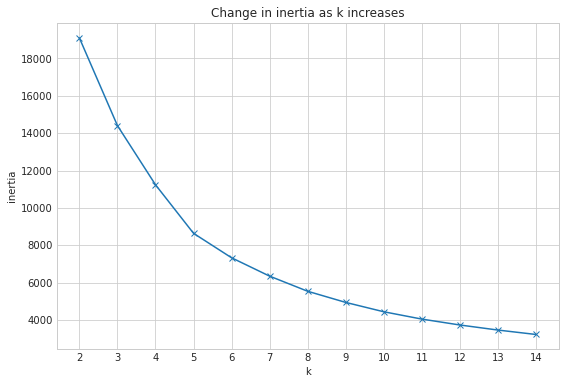

In [48]:
elbow_chart (train[X] , 15)

In [49]:
df, X_scaled, scaler, kmeans, centroids = create_cluster(train, validate, test, X ,5 , 'cluster_age_sqft')

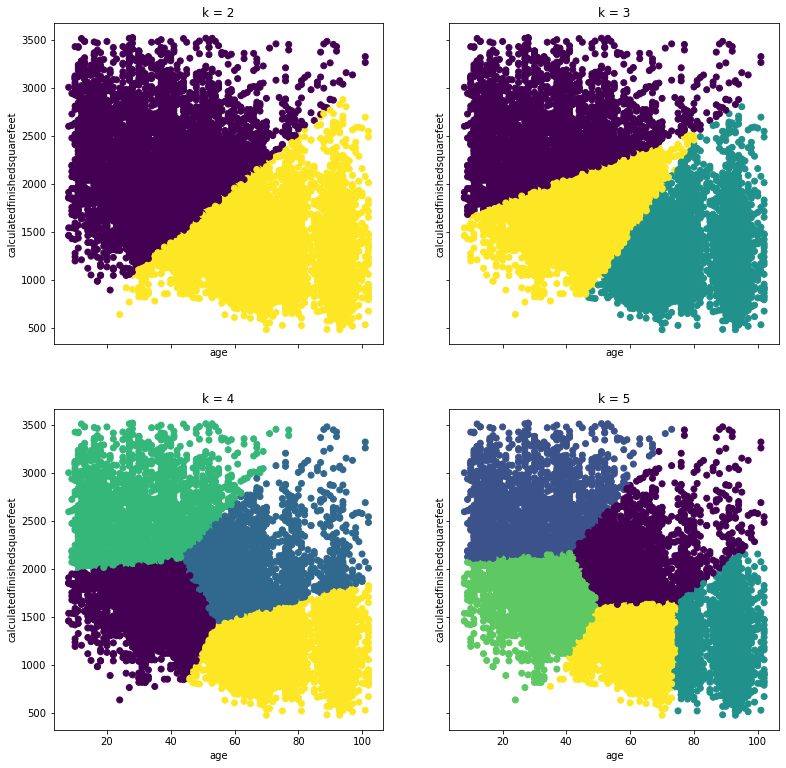

In [50]:
scatter_plot_ks (train, X_scaled, 'age', 'calculatedfinishedsquarefeet', 2, 7)

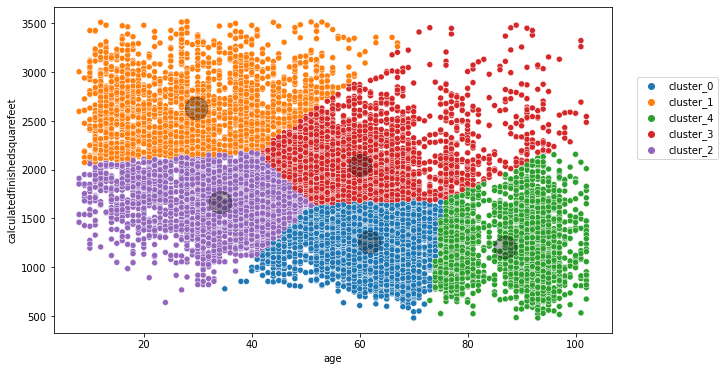

In [51]:
create_scatter_plot('age', 'calculatedfinishedsquarefeet',df,kmeans, X_scaled, scaler, 'cluster_age_sqft')

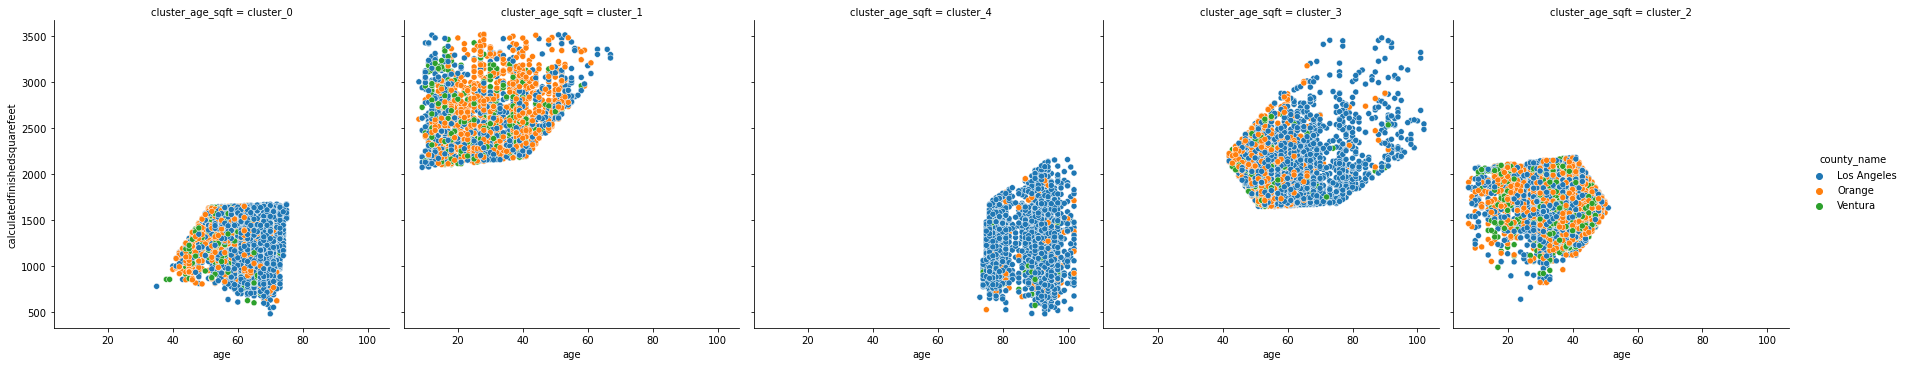

In [52]:
sns.relplot(x = 'age', y = 'calculatedfinishedsquarefeet', data = df, col = 'cluster_age_sqft', hue = 'county_name')

- $H_0$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.
- $H_a$:  There is no  difference in the overall mean error and the mean of the clusters' log_errors.

In [53]:
cluster0 = train[train.cluster_age_sqft == 'cluster_0'].logerror
cluster1 = train[train.cluster_age_sqft == 'cluster_1'].logerror
cluster2 = train[train.cluster_age_sqft == 'cluster_2'].logerror
cluster3 = train[train.cluster_age_sqft == 'cluster_3'].logerror
cluster4 = train[train.cluster_age_sqft == 'cluster_4'].logerror

list_cluster = [cluster0,cluster1,cluster2,cluster3,cluster4]

stat_ttest (train, list_cluster, 5)

For cluster_0, We fail to reject the null hypothesis
t = -0.06843684133722643,    p= 0.9454397850453974
For cluster_1, We reject the null hypothesis
t = 2.458212583007908,    p= 0.014036610545562603
For cluster_2, We fail to reject the null hypothesis
t = -1.2048215564457831,    p= 0.22835349300968108
For cluster_3, We fail to reject the null hypothesis
t = 1.4697992497460146,    p= 0.14170150133486697
For cluster_4, We reject the null hypothesis
t = -2.7393896199203245,    p= 0.006201198944741097


**takeaways**
- for the cluster age vs bedroom Clusters 0 is a  good candidate for modeling
- for the cluster latitude vs longitud Clusters 1,3  are   good candidates for modeling
- for the cluster  lotsize_acres vs calculatedfinishedsquarefeet Clusters 1 is a  good candidate for modeling
- for the cluster age', 'calculatedfinishedsquarefeet Clusters 1,4 are   good candidates for modeling



# Modeling

In [54]:
train.shape, validate.shape, test.shape

((19110, 28), (8190, 28), (6826, 28))

In [58]:
list_cluster = train.columns.to_list()

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19110 entries, 54155 to 12794
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   parcelid                      19110 non-null  object  
 1   bathroomcnt                   19110 non-null  float64 
 2   bedroomcnt                    19110 non-null  float64 
 3   calculatedfinishedsquarefeet  19110 non-null  float64 
 4   latitude                      19110 non-null  float64 
 5   longitude                     19110 non-null  float64 
 6   propertylandusetypeid         19110 non-null  float64 
 7   regionidcity                  19110 non-null  float64 
 8   regionidcounty                19110 non-null  float64 
 9   regionidzip                   19110 non-null  float64 
 10  structuretaxvaluedollarcnt    19110 non-null  float64 
 11  landtaxvaluedollarcnt         19110 non-null  float64 
 12  logerror                      19110 non-nu

In [60]:
cat_var = list_cluster[-5:]
cat_var

['cluster_age_bed',
 'cluster_lat_long',
 'cluster_lot_finish',
 'cluster_quadrimester_zipcode',
 'cluster_age_sqft']

In [61]:
train.shape, validate.shape, test.shape

((19110, 28), (8190, 28), (6826, 28))

In [62]:
#train
dummies =  pd.get_dummies(train[cat_var])
train = pd.concat([train, dummies], axis=1)
train = train.drop(columns=cat_var)

#validate
dummies =  pd.get_dummies(validate[cat_var])
validate = pd.concat([validate, dummies], axis=1)
validate = validate.drop(columns=cat_var)

#test
dummies =  pd.get_dummies(test[cat_var])
test = pd.concat([test, dummies], axis=1)
test = test.drop(columns=cat_var)

In [63]:
train.shape, validate.shape, test.shape

((19110, 45), (8190, 45), (6826, 45))

In [64]:
X_train, y_train, X_validate, y_validate, X_test, y_test =p.split_Xy(train, validate, test, 'logerror')

X_train -> (19110, 44)               y_train->(19110,)
X_validate -> (8190, 44)         y_validate->(8190,) 
X_test -> (6826, 44)                  y_test>(6826,)


In [71]:
#conver y_train y _ validate to df
y_train = pd.DataFrame( {'actual': y_train})
y_validate = pd.DataFrame( {'actual': y_validate})
y_test = pd.DataFrame( {'actual': y_test})

ValueError: If using all scalar values, you must pass an index

In [72]:
#baseline

In [73]:
def baseline_errors(df, y, option = 'mean' ):
    '''
    Takes in a dataframe , y = column with actual_values 
    and calculate:
    sum of squared errors (SSE)
    explained sum of squares (ESS)
    total sum of squares (TSS)
    mean squared error (MSE)
    root mean squared error (RMSE)
    Returns a dictionary with all these values
    Example:
    baseline_mean_errors(y_train, 'actual', 'mean')
    '''
    #import
    from sklearn.metrics import  mean_squared_error
    from math import sqrt

    #baseline
    if option == 'mean':
        df['yhat_baseline_mean'] = df[y].mean()
        col = 'yhat_baseline_mean'
    elif option == 'median':
        df['yhat_baseline_median'] = df[y].median()
        col = 'yhat_baseline_median'
    else:
        return print("please select the correct option: 'mean' or 'median' ")
        
    

    #calculate SSE using sklearn
    SSE_baseline = mean_squared_error(df[y], df[col])*len(df)
    #explained sum of squares (ESS)
    ESS_b = ((df[col] - df[y].mean())**2).sum()
    #total sum of squares (TSS)
    TSS_b = ((df[y] - df[y].mean())**2).sum()
    #mean squared error (MSE)
    MSE_baseline = mean_squared_error(df[y], df[col])
    #root mean squared error (RMSE)
    RMSE_baseline = sqrt(MSE_baseline)
    
    #create dicc
    b ={
        'sse': SSE_baseline,
        'mse': MSE_baseline,
        'rmse': RMSE_baseline,
         'tss': TSS_b,
        'ess' : ESS_b,
        'mse': MSE_baseline,
        'r2': ESS_b/TSS_b,       
    }

    return b


In [74]:
#create baseline using mean (I'm using my function to calculate rmse)
tra_m = baseline_errors(y_train, 'actual', 'mean')
tra_m['rmse']

0.15646778738228076

In [75]:
#let's calculate baseline in validate
val_m = baseline_errors(y_validate, 'actual', 'mean')
val_m['rmse']

0.16247094513192856

In [76]:
metric_df = pd.DataFrame(data = [{
    'model': 'mean_baseline',
    'rmse_train' : tra_m['rmse'],
    'rmse_validate': val_m['rmse'],
    'rmse_difference' : abs(round(tra_m['rmse'] - val_m['rmse'], 4)),
    'r^2_validate' : val_m['r2']}])

In [77]:
metric_df

,model,rmse_train,rmse_validate,rmse_difference,r^2_validate
0,mean_baseline,0.156468,0.162471,0.006,0.0


In [78]:
X_train.columns.to_list()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'propertylandusetypeid',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'transactiondate',
 'county_name',
 'la_cnty',
 'orange_cnty',
 'ventura_cnty',
 'age',
 'taxrate',
 'quadrimester',
 'lotsize_acres',
 'logerror_bins',
 'cluster_age_bed_cluster_0',
 'cluster_age_bed_cluster_1',
 'cluster_age_bed_cluster_2',
 'cluster_age_bed_cluster_3',
 'cluster_age_bed_cluster_4',
 'cluster_lat_long_cluster_0',
 'cluster_lat_long_cluster_1',
 'cluster_lat_long_cluster_2',
 'cluster_lat_long_cluster_3',
 'cluster_lot_finish_cluster_0',
 'cluster_lot_finish_cluster_1',
 'cluster_lot_finish_cluster_2',
 'cluster_lot_finish_cluster_3',
 'cluster_quadrimester_zipcode_cluster_0',
 'cluster_quadrimester_zipcode_cluster_1',
 'cluster_quadrimester_zipcode_cluster_2',
 'cluster_quadrimester_zipcode_cluster_3',
 'cluster_age_sqft_cluster_0'

In [79]:
for the cluster age vs bedroom Clusters 0 is a good candidate for modeling
for the cluster latitude vs longitud Clusters 1,3 are good candidates for modeling
for the cluster lotsize_acres vs calculatedfinishedsquarefeet Clusters 1 is a good candidate for modeling
for the cluster age', 'calculatedfinishedsquarefeet Clusters 1,4 are good candidates for modeling

SyntaxError: invalid syntax (<ipython-input-79-917c421edf7b>, line 1)

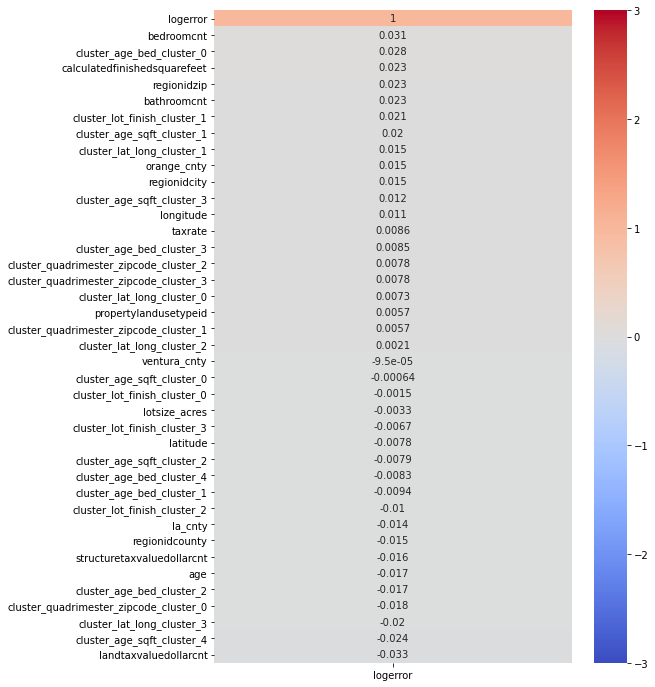

In [80]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-3, vmax=3, annot=True, cmap='coolwarm')

In [81]:
#select features
features = ['cluster_age_bed_cluster_0','cluster_lat_long_cluster_1', 'cluster_lat_long_cluster_3', 'cluster_lot_finish_cluster_1',
             'cluster_age_sqft_cluster_1', 'cluster_age_sqft_cluster_4', 'bedroomcnt', 'calculatedfinishedsquarefeet']

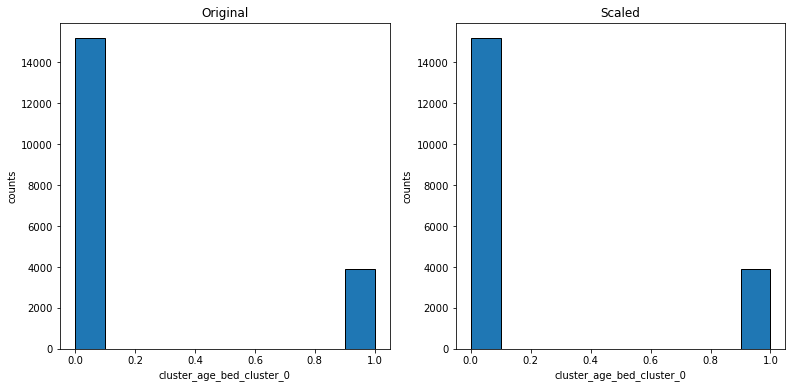

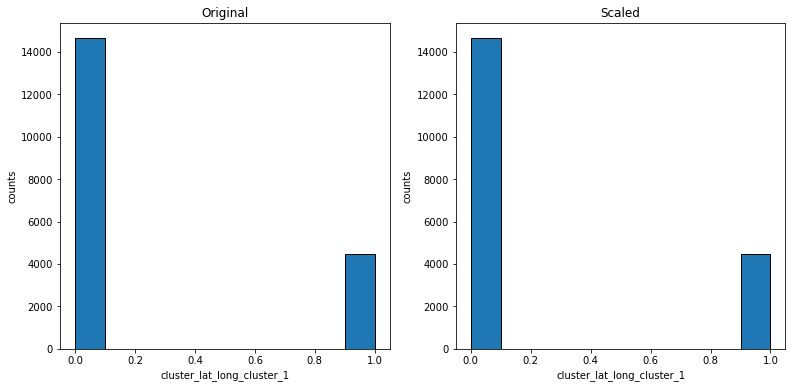

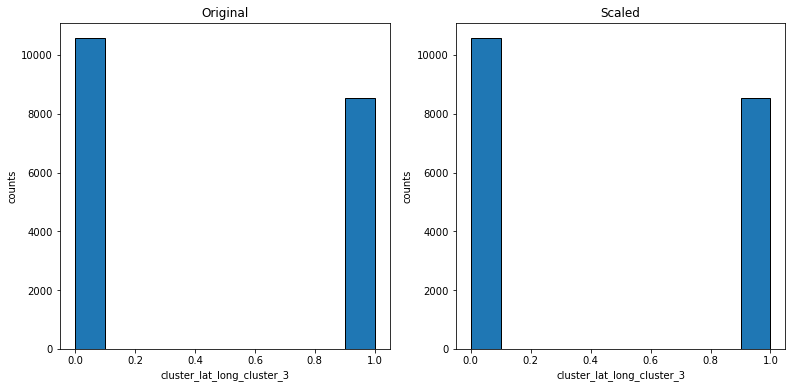

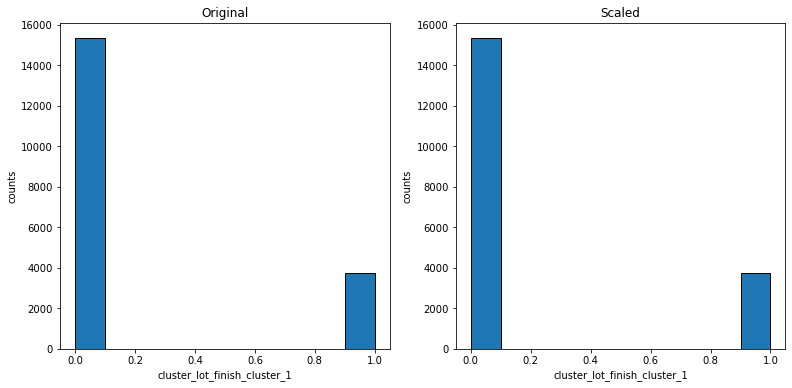

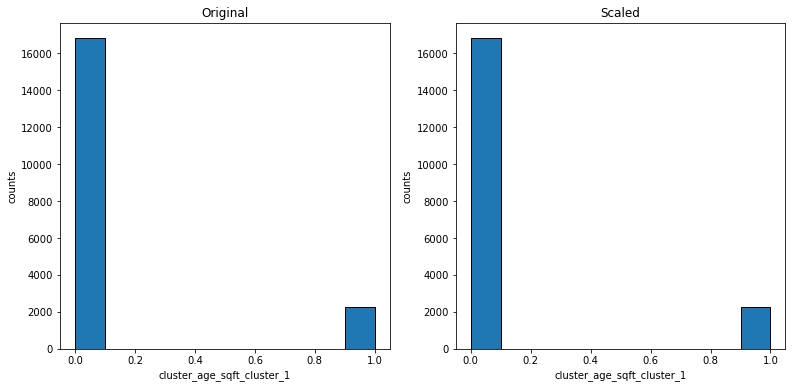

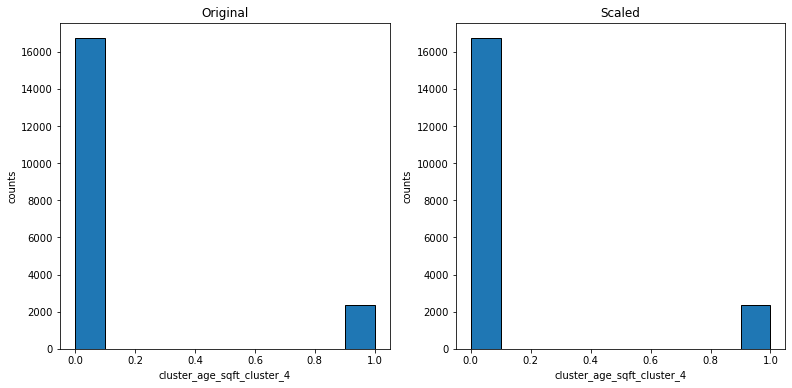

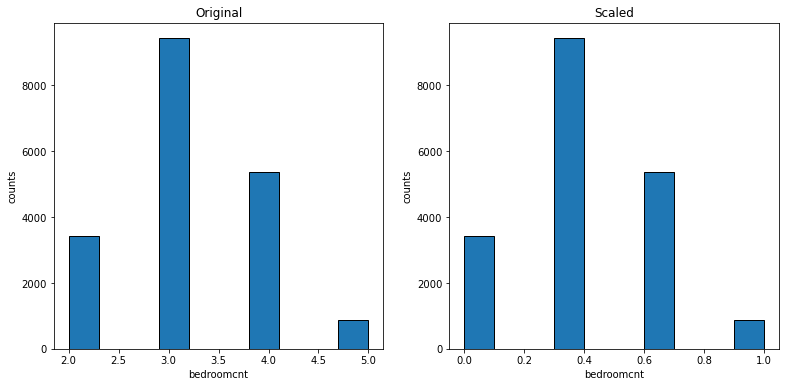

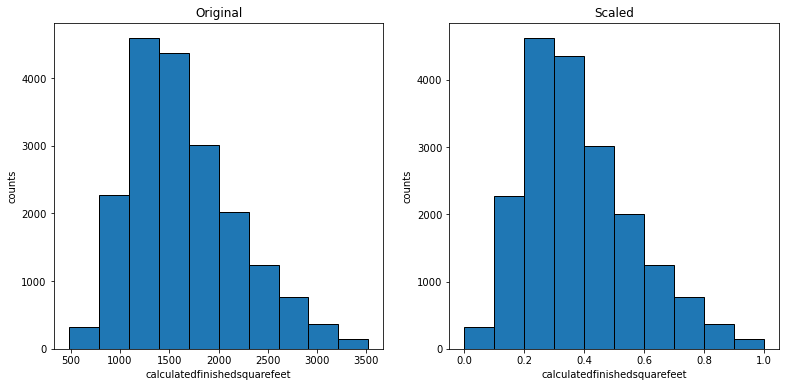

In [82]:
train_scaled_df, validate_scaled_df, test_scaled_df = p.scaled_df(X_train[features] , X_validate[features], X_test[features], features, MinMaxScaler())

## LassoLars

In [83]:
def regression_errors(df, y, yhat):
    '''
    Takes in a dataframe , y = column with actual_values and yhat= name of the columns with predicted_values
    and calculate:
    sum of squared errors (SSE)
    explained sum of squares (ESS)
    total sum of squares (TSS)
    mean squared error (MSE)
    root mean squared error (RMSE)
    Returns a dictionary with all these values.
    Example:
    plot_residuals(df, 'tip', 'yhat')
    '''
    #import
    from sklearn.metrics import  mean_squared_error
    from math import sqrt
    
    
    #calculate SSE using sklearn
    SSE = mean_squared_error(df[y], df[yhat])*len(df)
    #explained sum of squares (ESS)
    ESS = ((df[yhat] - df[y].mean())**2).sum()
    #total sum of squares (TSS)
    TSS = ((df[y] - df[y].mean())**2).sum()
    #mean squared error (MSE)
    MSE = mean_squared_error(df[y], df[yhat])
    #root mean squared error (RMSE)
    RMSE = sqrt(MSE)
    
    #create a dictionary
    m= {
        'sse': SSE,
        'ess': ESS,
        'rmse': RMSE,
        'tss': TSS,
        'mse': MSE,
        'r2': ESS/TSS,
    }

    return m

In [84]:
def create_model (X_df_scaled, y_df, actual, method, name):
    '''
    takes in features scaled df, target df, name of actual target, 
    type of method and the name of the selected method and 
    returns a dictionary that contains calculated regression errors.
    
    X_df_scaled : df that contains scaled featues
    y_df: target df
    actual: name of the column where is actual value of the target
    mehod: type of method to create the model object
    name: enter the new name for your model
    
    Example:
    create_model(X_train_scaled[top_sb], y_train, 'actual', LinearRegression(normalize=True), 'modelOLS' )
    '''
    # fit the thing
    method.fit(X_df_scaled, y_df[actual])

    # predict train
    y_df[name] = method.predict(X_df_scaled)

    #calculate regression errors using a created function
    train_eval = regression_errors(y_df, actual, name)

    return train_eval

In [85]:
def select_rfe (X_df, y_df, n_features, method):
    '''
    Takes in the predictors, the target, and the number of features to select (k) ,
    and returns the names of the top k selected features based on the Recursive Feature Elimination (RFE)
    
    X_df : the predictors
    y_df : the target
    n_features : the number of features to select (k)
    method : LinearRegression, LassoLars, TweedieRegressor
    Example
    select_rfe(X_train_scaled, y_train, 2, LinearRegression())
    '''
    from sklearn.feature_selection import RFE
    lm = method
    rfe = RFE(estimator=lm, n_features_to_select= n_features)
    rfe.fit(X_df, y_df)
    top_rfe = list(X_df.columns[rfe.support_])
    print(f'The top {n_features} selected feautures based on the the RFE class class are: {top_rfe}' )
    print(pd.Series(dict(zip(X_df.columns, rfe.ranking_))).sort_values())
    return top_rfe

In [86]:
top_rfe = select_rfe(train_scaled_df, y_train, 4,  LassoLars(alpha=1, random_state =123) )
top_rfe

The top 4 selected feautures based on the the RFE class class are: ['cluster_age_sqft_cluster_1', 'cluster_age_sqft_cluster_4', 'bedroomcnt', 'calculatedfinishedsquarefeet']
cluster_age_sqft_cluster_1      1
cluster_age_sqft_cluster_4      1
bedroomcnt                      1
calculatedfinishedsquarefeet    1
cluster_lot_finish_cluster_1    2
cluster_lat_long_cluster_3      3
cluster_lat_long_cluster_1      4
cluster_age_bed_cluster_0       5
dtype: int64


['cluster_age_sqft_cluster_1',
 'cluster_age_sqft_cluster_4',
 'bedroomcnt',
 'calculatedfinishedsquarefeet']

In [87]:
#using selected features with RFE
lasso = create_model(train_scaled_df[top_rfe], y_train, 'actual', LassoLars(alpha=1, random_state =123), 'model_lasso' )
lasso['rmse']

0.15646778738228076

In [88]:
0.156468
0.15646778738228076

0.15646778738228076

In [89]:
lassoval = create_model(validate_scaled_df[top_rfe], y_validate, 'actual', LassoLars(alpha=1, random_state=123), 'model_lasso' )
lassoval['rmse']

0.16247094513192856

In [90]:
print('Train rmse:  ',lasso['rmse'])
print('validate rmse', lassoval['rmse'])

Train rmse:   0.15646778738228076
validate rmse 0.16247094513192856


In [91]:
metric_df = metric_df.append(
    {
    'model': 'lasso',
    'rmse_train': lasso['rmse'],
    'rmse_validate': lassoval['rmse'],
    'rmse_difference' :abs( round(lasso['rmse'] - lassoval['rmse'], 4)),
    'r^2_validate' : lassoval['r2']}, ignore_index = True)

In [92]:
metric_df

,model,rmse_train,rmse_validate,rmse_difference,r^2_validate
0,mean_baseline,0.156468,0.162471,0.006,0.000000e+00
1,lasso,0.156468,0.162471,0.006,2.412264e-31


In [93]:
## TweedieRegressor (GLM

In [94]:
#train
glm_train = create_model(train_scaled_df[top_rfe], y_train, 
                           'actual', TweedieRegressor(power=0, alpha=0), 'model_glm' )

In [95]:
#validate
glm_val = create_model(validate_scaled_df[top_rfe], y_validate, 
                         'actual', TweedieRegressor(power=0, alpha=0), 'model_glm' )

In [96]:
print('Train rmse:  ',glm_train['rmse'])
print('validate rmse', glm_val['rmse'])

Train rmse:   0.1563709875871793
validate rmse 0.16235479946127104


In [97]:
metric_df = metric_df.append(
    {
    'model': 'glm',
    'rmse_train' : glm_train['rmse'],   
    'rmse_validate': glm_val['rmse'],
    'rmse_difference' : abs(round(glm_train['rmse'] - glm_val['rmse'], 4)),
    'r^2_validate' : glm_val['r2']}, ignore_index = True)

In [98]:
metric_df

,model,rmse_train,rmse_validate,rmse_difference,r^2_validate
0,mean_baseline,0.156468,0.162471,0.006,0.000000e+00
1,lasso,0.156468,0.162471,0.006,2.412264e-31
2,glm,0.156371,0.162355,0.006,1.436922e-03


In [99]:
### Polynomial Regression

In [100]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree = 7) 

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(train_scaled_df)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(validate_scaled_df)
X_test_degree3 = pf.transform(test_scaled_df)

In [101]:
#train
pol_reg_train =  create_model(X_train_degree3, y_train, 
                                'actual', LinearRegression(normalize=True), 'model_polreg' )

In [102]:
#validate
pol_reg_val =  create_model(X_validate_degree3, 
                              y_validate, 'actual',LinearRegression(normalize=True), 'model_polreg' )

KeyboardInterrupt: 

In [ ]:
print('Train rmse:  ',pol_reg_train['rmse'])
print('validate rmse', pol_reg_val['rmse'])

In [ ]:
metric_df = metric_df.append(
    {
    'model': 'pol_reg',
    'rmse_train': pol_reg_train['rmse'],
    'rmse_validate': pol_reg_val['rmse'],
    'rmse_difference' : abs(round(pol_reg_train['rmse'] - pol_reg_val['rmse'], 4)),
    'r^2_validate' : pol_reg_val['r2']},  ignore_index = True)

In [ ]:
metric_df

In [ ]:
def report(metric_df):
    
    from IPython.display import display, HTML
    rmse_base = metric_df.iloc[0,2]
    print(f'These are the models that perform better than our baseline rmse: {rmse_base}')
    dfs =metric_df[['model', 'rmse_validate']][metric_df['rmse_validate'] < rmse_base]
    display(HTML(dfs.to_html()))
    
    
    min_val = metric_df['rmse_validate'].idxmin()
    metric_df.iloc[min_val][0]
    rsme_bet = round(metric_df['rmse_validate'].iloc[min_val], 2)
    print('-----------------------------------------------------------------------------------------------')
    print(f'   ********** The model with the less  rmse_validate  is {metric_df.iloc[min_val][0] }  rmse:{rsme_bet} **********             ')
    print('-----------------------------------------------------------------------------------------------')
    print(' ')
    min_val = metric_df['r^2_validate'].idxmax()
    metric_df.iloc[min_val][0]
    print(f'The model with r^2 validate closer to 1 is ', metric_df.iloc[min_val][0])
    
    display(HTML(metric_df.to_html()))
    return

In [ ]:
#I use this function that gives me a report based on metric_df
report (metric_df)

In [ ]:
## Test the best model

In [ ]:
#use my function to create and calculate the metrics
pol_reg_test =  m.create_model(X_test_degree2, 
                              y_test, 'actual',LinearRegression(normalize=True), 'model_polreg' )

In [ ]:
#I;m goung to create a new table only with my baseline and my best model
best_model = metric_df.drop([1,2,3], axis= 0)
best_model

In [ ]:
#add the resutl of test
best_model[' rmse_test'] =  pol_reg_test['rmse']
best_model.iloc[0,5] = 0

In [ ]:
best_model

In [ ]:

plt.figure(figsize=(16,8))
plt.plot(y_validate.actual, y_validate.yhat_baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", ( 8000_000, 1))
plt.plot(y_validate.actual, y_validate.actual, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.8 *(10**7), .95 *(10**7)), rotation=25)
#these are my oder models if I want to see them too
#plt.scatter(y_validate.actual, y_validate.modelOLS, 
#           alpha=.5, color="red", s=100, label="Model: LinearRegression")
#plt.scatter(y_validate.actual, y_validate.model_lasso, 
#            alpha=.5, color="blue", s=100, label="Model: LASSO")
#plt.scatter(y_validate.actual, y_validate.model_glm, 
#            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.actual, y_validate.model_polreg, 
            alpha=.5, color="green", s=100, label="Model 21 degree Polynomial")
plt.legend()
plt.xlabel("ActualAssessed value")
plt.ylabel("Predicted assessed value")
plt.yscale(value = 'linear')
plt.title(" Actual vs. Predicted Values")

plt.show()